# SVO Verbs  Lemmatized

Initial note on lemmatizing: https://stackoverflow.com/questions/51658153/lemmatize-a-doc-with-spacy

In [1]:
# IMPORTS
import re, spacy, textacy
import pandas as pd
import numpy as np


In [2]:
import matplotlib.pyplot as plt

In [3]:
# DATA LOAD
# Loading the Data in a gendered partitioned fashion: 
talks_m = pd.read_csv('../output/talks_male.csv', index_col='Talk_ID')
talks_f = pd.read_csv('../output/talks_female.csv', index_col='Talk_ID')
talks_nog = pd.read_csv('../output/talks_nog.csv', index_col='Talk_ID')
talks_all = pd.concat([talks_m, talks_f, talks_nog])

# GETTING JUST THE TEXTS
texts_all = talks_all.text.tolist()
texts_women = talks_f.text.tolist()
texts_men = talks_m.text.tolist()

# Lowercase everything before we create spaCy doc and Textacy SVO triple
texts_w = [text.lower() for text in texts_women]
texts_m = [text.lower() for text in texts_men]

In [4]:
# Get talkIDs in order
m_talkIDs = talks_m.index.values.tolist()
w_talkIDs = talks_f.index.values.tolist()

## From Texts to SVOs

In [4]:
# Load the Space pipeline to be used
nlp = spacy.load('en_core_web_sm')
# nlp.add_pipe('sentencizer')
# nlp.remove_pipe("lemmatizer")
# nlp.add_pipe("lemmatizer", config={"mode": "lookup"}).initialize()

In [5]:
# Use the pipe method to feed documents 
docs_w = list(nlp.pipe(texts_w))
docs_m = list(nlp.pipe(texts_m))

# A quick check of our work:
docs_m[0]._.preview

KeyboardInterrupt: 

## SVOs to Dataframe

Since we create SVOs for every sentence in the two subcorpora, why not save both to two dataframes?

In [6]:
def createSVOs(doc, svo_list):
    # Create the list of tuples for the document
    svotriples = list(textacy.extract.triples.subject_verb_object_triples(doc))
    # Convert to list of dictionaries
    for item in svotriples:
        svo_list.append(
            {
                'subject': str(item[0][-1]), 
                'verb': str(item[1][-1]), 
                'object': str(item[2])
            }
        )

In [7]:
# Code based on above function by JL

def createSVOs_by_talk(doc, all_svo_list):
    # Create the list of tuples for the document
    svotriples = list(textacy.extract.triples.subject_verb_object_triples(doc))
    # Convert to list of dictionaries
    talk_list = []
    for item in svotriples:
        talk_list.append(
            {
                'subject': str(item[0][-1]), 
                'verb': str(item[1][-1]), 
                'object': str(item[2])
            }
        )
    all_svo_list.append(talk_list)

In [8]:
def createSVOs_tID(doc, svo_list, talkID=None):
    # Create the list of tuples for the document
    svotriples = list(textacy.extract.triples.subject_verb_object_triples(doc))
    # Convert to list of dictionaries
    for item in svotriples:
        svo_list.append(
            {
                'subject': str(item[0][-1]), 
                'verb': str(item[1][-1]), 
                'object': str(item[2]),
                'TalkID':talkID
            }
        )

### Now at Scale

In [ ]:
# Create the two lists
svos_m_by_talk = []
svos_w_by_talk = []

# Populate the lists with SVO triples
for m in range(len(m_talkIDs)):
    doc = docs_m[m]
    talkID = m_talkIDs[m]
    createSVOs_tID(doc, svos_m_by_talk, talkID)

for w in range(len(w_talkIDs)):
    doc = docs_w[w]
    talkID = w_talkIDs[w]
    createSVOs_tID(doc, svos_w_by_talk, talkID)

In [ ]:
svos_m_by_talk

In [ ]:
svos_mbt = pd.DataFrame(svos_m_by_talk)
svos_wbt = pd.DataFrame(svos_w_by_talk)

In [ ]:
svos_mbt

### Post-SVO Lemmatizing

Two possible approaches to lemmatizing verbs in a dataframe:
* [How to lemmatise a dataframe column Python - Stack Overflow](https://stackoverflow.com/questions/61987040/how-to-lemmatise-a-dataframe-column-python)
* [dataframe - lemmatizing a verb list in a data frame in Python - Stack Overflow](https://stackoverflow.com/questions/72394840/lemmatizing-a-verb-list-in-a-data-frame-in-python)

In [ ]:
from nltk.stem import WordNetLemmatizer

In [ ]:
# https://www.nltk.org/_modules/nltk/stem/wordnet.html
wnl = WordNetLemmatizer()
svos_wbt.verb.map(lambda word: wnl.lemmatize(word, pos="v"))

In [ ]:
svos_wbt.shape

In [ ]:
svos_wbt


In [ ]:
svos_mbt.verb = svos_mbt.verb.map(lambda word: wnl.lemmatize(word, pos="v"))

In [ ]:
svos_wbt.verb = svos_wbt.verb.map(lambda word: wnl.lemmatize(word, pos="v"))

In [ ]:
svos_wbt.shape[0]+svos_mbt.shape[0]

In [ ]:
# Save to CSV files 
# >>> Commented out once run
svos_wbt.to_csv("../output/svos_wbt_lem.csv")
svos_mbt.to_csv("../output/svos_mbt_lem.csv")

In [5]:
svos_wbt = pd.read_csv('../output/svos_wbt_lem.csv')
svos_mbt = pd.read_csv('../output/svos_mbt_lem.csv')

svos_wbt = svos_wbt.drop(columns = ["Unnamed: 0"])
svos_mbt = svos_mbt.drop(columns = ["Unnamed: 0"])

## SV Pairs with "She", "He", and "I" by speaker

Merging code from `Gender-SV-TFIDF-ajbc` into here

In [57]:
# From Allison code

# Create a list of the pronouns we want to see
pronouns = ["he", "she", "i"]

# Function to retrive the count the number of times subjects,
# here a list of pronouns, are paired with verbs
def svPairs (df, pplist):    
    temp = df[df["subject"].isin(
        pplist)].value_counts(
        subset=['subject', 'verb']).reset_index()
    # Re-label the new column from "count"
    temp.rename(columns={0 : 'term_freq'}, inplace=True)
    # Allison's OG code
    #temp.rename(columns={'count' : 'term_freq'}, inplace=True)
    
    # Add a column with relative frequency
    temp['term_rfreq'] = temp['term_freq'] / df.shape[0]

    temp2 = df[df["subject"].isin(
        pplist)].value_counts(
        subset=['TalkID', 'subject', 'verb']).reset_index()
    
    # Add below line 
    temp2.rename(columns={0 : 'term_freq'}, inplace=True)
    # Re-label the new column from "count"
    return temp, temp2

In [58]:
m_pp_v, m_pp_v_doc  = svPairs(svos_mbt, pronouns)
w_pp_v, w_pp_v_doc = svPairs(svos_wbt, pronouns)

print(m_pp_v.shape)
print(w_pp_v.shape)

(1718, 4)
(1057, 4)


In [12]:
m_pp_v.head()

,subject,verb,term_freq,term_rfreq
0,i,have,1310,0.016263
1,i,want,1207,0.014984
2,i,go,1062,0.013184
3,i,do,645,0.008007
4,i,get,589,0.007312


In [13]:
m_pp_v_doc.head()

,TalkID,subject,verb,term_freq
0,353,i,want,21
1,172,i,have,19
2,188,i,get,18
3,114,i,want,17
4,231,i,do,17


In [59]:
def svPairDocFreq(df):  
    """This counts the number of documents that the SV pair occurs in"""
    temp = df.value_counts(
        subset=['subject', 'verb']).reset_index()

    # Allison's OG code
    # temp.rename(columns={'count' : 'doc_freq'}, inplace=True)
    temp.rename(columns={0 : 'doc_freq'}, inplace=True)
    return temp

In [60]:
m_pp_v_df  = svPairDocFreq(m_pp_v_doc)
m_pp_v_df.head()

,subject,verb,doc_freq
0,i,have,432
1,i,want,430
2,i,go,376
3,i,get,291
4,i,do,274


In [16]:
m_pp_v.head()

,subject,verb,term_freq,term_rfreq
0,i,have,1310,0.016263
1,i,want,1207,0.014984
2,i,go,1062,0.013184
3,i,do,645,0.008007
4,i,get,589,0.007312


In [17]:
m_pp_v_df = m_pp_v_df.merge(m_pp_v)

In [18]:
m_pp_v_df.head()

,subject,verb,doc_freq,term_freq,term_rfreq
0,i,have,432,1310,0.016263
1,i,want,430,1207,0.014984
2,i,go,376,1062,0.013184
3,i,get,291,589,0.007312
4,i,do,274,645,0.008007


In [61]:
# Get document frequencies
m_pp_v_df  = svPairDocFreq(m_pp_v_doc)
w_pp_v_df = svPairDocFreq(w_pp_v_doc)

m_pp_v_df = m_pp_v_df.merge(m_pp_v)
w_pp_v_df = w_pp_v_df.merge(w_pp_v)

m_docs = len(pd.unique(m_pp_v_doc['TalkID']))
w_docs = len(pd.unique(w_pp_v_doc['TalkID']))

m_pp_v_df['tfidf'] = m_pp_v_df['term_freq'] / np.log(m_docs / m_pp_v_df['doc_freq'])
w_pp_v_df['tfidf'] = w_pp_v_df['term_freq'] / np.log(w_docs / w_pp_v_df['doc_freq'])
#m_pp_v_df['tf_gidf'] = m_pp_v_df['term_freq'] / np.log(m_docs / m_pp_v_df['doc_freq'])
#w_pp_v_df['tf_gidf'] = w_pp_v_df['term_freq'] / np.log(w_docs / w_pp_v_df['doc_freq'])

#m_pp_v_df['tfidf'] = m_pp_v_df['term_freq'] / np.log((m_docs+w_docs) / m_pp_v_df['doc_freq'])
#w_pp_v_df['tfidf'] = w_pp_v_df['term_freq'] / np.log((m_docs+w_docs) / w_pp_v_df['doc_freq'])

m_pp_v_df['speaker_gender'] = 'man'
w_pp_v_df['speaker_gender'] = 'woman'
df = pd.concat([m_pp_v_df, w_pp_v_df])
df['tuple'] = df["subject"] + ' ' + df["verb"]
df=df.reindex(columns=['speaker_gender', 'subject', 'verb', 'term_freq', 'doc_freq', 'tfidf'])

df

,speaker_gender,subject,verb,term_freq,doc_freq,tfidf
0,man,i,have,1310,432,2690.317896
1,man,i,want,1207,430,2455.389603
2,man,i,go,1062,376,1697.115268
3,man,i,get,589,291,667.774996
4,man,i,do,645,274,684.547118
...,...,...,...,...,...,...
1052,woman,i,jacques,1,1,0.180592
1053,woman,i,judge,1,1,0.180592
1054,woman,i,kick,1,1,0.180592
1055,woman,i,knit,1,1,0.180592


In [ ]:
df.to_csv("../output/tfidf_by_speaker.csv")

In [9]:
df = pd.read_csv("../output/tfidf_by_speaker.csv")
df = df.drop(columns = ["Unnamed: 0"])

In [10]:
df

,speaker_gender,subject,verb,term_freq,doc_freq,tfidf
0,man,i,have,1310,432,2690.317896
1,man,i,want,1207,430,2455.389603
2,man,i,go,1062,376,1697.115268
3,man,i,get,589,291,667.774996
4,man,i,do,645,274,684.547118
...,...,...,...,...,...,...
2770,woman,i,jacques,1,1,0.180592
2771,woman,i,judge,1,1,0.180592
2772,woman,i,kick,1,1,0.180592
2773,woman,i,knit,1,1,0.180592


## Get TFIDF for the SV regardless of speaker

Here we get the TFIDF for the (subject, verb) tuples regardless of gender. As before we only include the (S,V) pairs where the subjects are from the pronoun list `['he', 'she', 'i']`

In [21]:
svos_bt = pd.concat([svos_wbt,svos_mbt])

In [23]:
a_docs = len(pd.unique(svos_bt['TalkID']))

In [21]:
a_pp_v, a_pp_v_doc  = svPairs(svos_bt, pronouns)


In [22]:
a_pp_v

,subject,verb,term_freq,term_rfreq
0,i,have,1891,0.017647
1,i,want,1634,0.015248
2,i,go,1389,0.012962
3,i,do,864,0.008063
4,i,get,787,0.007344
...,...,...,...,...
2086,i,acknowledge,1,0.000009
2087,he,note,1,0.000009
2088,i,rationalize,1,0.000009
2089,he,not,1,0.000009


In [23]:
a_pp_v_df  = svPairDocFreq(a_pp_v_doc)


In [24]:
a_pp_v_df

,subject,verb,doc_freq
0,i,have,599
1,i,want,576
2,i,go,508
3,i,get,390
4,i,do,375
...,...,...,...
2086,i,market,1
2087,i,mark,1
2088,i,maria,1
2089,i,mar,1


In [25]:
a_pp_v_df = a_pp_v_df.merge(a_pp_v)

In [26]:
a_pp_v_df

,subject,verb,doc_freq,term_freq,term_rfreq
0,i,have,599,1891,0.017647
1,i,want,576,1634,0.015248
2,i,go,508,1389,0.012962
3,i,get,390,787,0.007344
4,i,do,375,864,0.008063
...,...,...,...,...,...
2086,i,market,1,1,0.000009
2087,i,mark,1,1,0.000009
2088,i,maria,1,1,0.000009
2089,i,mar,1,1,0.000009


In [29]:
# Spot check

i_have = df[df["verb"] == 'have']
i_have = i_have[i_have["subject"] == "i"]
sum(i_have["term_freq"])

1891

In [30]:
# Get document frequencies
a_pp_v_df  = svPairDocFreq(a_pp_v_doc)

a_pp_v_df = a_pp_v_df.merge(a_pp_v)

a_docs = len(pd.unique(a_pp_v_doc['TalkID']))

a_pp_v_df['tfidf'] = a_pp_v_df['term_freq'] / np.log(a_docs / a_pp_v_df['doc_freq'])


af = a_pp_v_df
af['tuple'] = af["subject"] + ' ' + af["verb"]
af=af.reindex(columns=['subject', 'verb', 'term_freq', 'doc_freq', 'tfidf'])

af

,subject,verb,term_freq,doc_freq,tfidf
0,i,have,1891,599,4035.925988
1,i,want,1634,576,3218.463148
2,i,go,1389,508,2193.197336
3,i,get,787,390,876.727196
4,i,do,864,375,922.212481
...,...,...,...,...,...
2086,i,market,1,1,0.145692
2087,i,mark,1,1,0.145692
2088,i,maria,1,1,0.145692
2089,i,mar,1,1,0.145692


In [ ]:
af.to_csv("../output/tfidf_all_speakers.csv")

In [11]:
af = pd.read_csv("../output/tfidf_all_speakers.csv")
af = af.drop(columns = ["Unnamed: 0"])

In [12]:
af

,subject,verb,term_freq,doc_freq,tfidf
0,i,have,1891,599,4035.925988
1,i,want,1634,576,3218.463148
2,i,go,1389,508,2193.197336
3,i,get,787,390,876.727196
4,i,do,864,375,922.212481
...,...,...,...,...,...
2086,i,market,1,1,0.145692
2087,i,mark,1,1,0.145692
2088,i,maria,1,1,0.145692
2089,i,mar,1,1,0.145692


## Get TFIDF for the verbs

First by speaker, then all together

In [31]:
# From Allison code

# Create a list of the pronouns we want to see
pronouns = ["he", "she", "i"]

# Function to retrive the count the number of times verbs
# appear with the given list of pronouns
def v_subset_pronouns(df, pplist):    
    temp = df[df["subject"].isin(pplist)].value_counts(
        subset=['verb']).reset_index()
    # Re-label the new column from "count"
    temp.rename(columns={0 : 'term_freq'}, inplace=True)
    # Allison's OG code
    #temp.rename(columns={'count' : 'term_freq'}, inplace=True)
    
    # Add a column with relative frequency
    temp['term_rfreq'] = temp['term_freq'] / df.shape[0]

    temp2 = df[df["subject"].isin(
        pplist)].value_counts(
        subset=['TalkID', 'verb']).reset_index()
    
    # Add below line 
    temp2.rename(columns={0 : 'term_freq'}, inplace=True)
    # Re-label the new column from "count"
    return temp, temp2

In [32]:
m_v, m_v_doc  = v_subset_pronouns(svos_mbt, pronouns)
w_v, w_v_doc  = v_subset_pronouns(svos_wbt, pronouns)

In [33]:
def vDocFreq(df):  
    """This counts the number of documents that the verb occurs in"""
    temp = df.value_counts(
        subset=['verb']).reset_index()

    # Allison's OG code
    # temp.rename(columns={'count' : 'doc_freq'}, inplace=True)
    temp.rename(columns={0 : 'doc_freq'}, inplace=True)
    return temp

In [34]:
m_v_df  = vDocFreq(m_v_doc)
m_v_df.head()

,verb,doc_freq
0,have,484
1,want,451
2,go,405
3,get,330
4,do,309


In [35]:
# Get document frequencies
m_v_df  = vDocFreq(m_v_doc)
w_v_df  = vDocFreq(w_v_doc)

m_v_df = m_v_df.merge(m_v)
w_v_df = w_v_df.merge(w_v)

m_docs = len(pd.unique(m_pp_v_doc['TalkID']))
w_docs = len(pd.unique(w_pp_v_doc['TalkID']))

m_v_df['tfidf'] = m_v_df['term_freq'] / np.log(m_docs / m_v_df['doc_freq'])
w_v_df['tfidf'] = w_v_df['term_freq'] / np.log(w_docs / w_v_df['doc_freq'])
#m_pp_v_df['tf_gidf'] = m_pp_v_df['term_freq'] / np.log(m_docs / m_pp_v_df['doc_freq'])
#w_pp_v_df['tf_gidf'] = w_pp_v_df['term_freq'] / np.log(w_docs / w_pp_v_df['doc_freq'])

#m_pp_v_df['tfidf'] = m_pp_v_df['term_freq'] / np.log((m_docs+w_docs) / m_pp_v_df['doc_freq'])
#w_pp_v_df['tfidf'] = w_pp_v_df['term_freq'] / np.log((m_docs+w_docs) / w_pp_v_df['doc_freq'])

m_v_df['speaker_gender'] = 'man'
w_v_df['speaker_gender'] = 'woman'
dv = pd.concat([m_v_df, w_v_df])

dv=dv.reindex(columns=['speaker_gender', 'verb', 'term_freq', 'doc_freq', 'tfidf'])

dv

,speaker_gender,verb,term_freq,doc_freq,tfidf
0,man,have,1633,484,4374.826039
1,man,want,1310,451,2951.184576
2,man,go,1179,405,2137.922960
3,man,get,697,330,921.635542
4,man,do,790,309,961.052303
...,...,...,...,...,...
710,woman,hunch,1,1,0.180592
711,woman,hound,1,1,0.180592
712,woman,hop,1,1,0.180592
713,woman,hasten,1,1,0.180592


In [ ]:
dv.to_csv("../output/tfidf_just_verbs.csv")

In [13]:
dv = pd.read_csv("../output/tfidf_just_verbs.csv")
dv = dv.drop(columns = ["Unnamed: 0"])

## Now do the above for all verbs regardless of speaker


In [39]:
a_v, a_v_doc  = v_subset_pronouns(svos_bt, pronouns)

In [42]:
a_v_df  = vDocFreq(a_v_doc)

In [43]:
a_v_df

,verb,doc_freq
0,have,669
1,want,605
2,go,542
3,get,444
4,do,425
...,...,...
1372,increase,1
1373,induce,1
1374,inflict,1
1375,inform,1


In [45]:
# Get document frequencies
a_v_df  = vDocFreq(a_v_doc)

a_v_df = a_v_df.merge(a_v)

a_docs = len(pd.unique(a_v_doc['TalkID']))

a_v_df['tfidf'] = a_v_df['term_freq'] / np.log(a_docs / a_v_df['doc_freq'])

av = a_v_df
av=av.reindex(columns=['verb', 'term_freq', 'doc_freq', 'tfidf'])

av

,verb,term_freq,doc_freq,tfidf
0,have,2356,669,6580.650244
1,want,1767,605,3853.241578
2,go,1557,542,2738.606163
3,get,936,444,1218.783597
4,do,1070,425,1318.197920
...,...,...,...,...
1372,increase,1,1,0.145692
1373,induce,1,1,0.145692
1374,inflict,1,1,0.145692
1375,inform,1,1,0.145692


In [46]:
av.to_csv("../output/tfidf_just_verbs_all_speakers.csv")

In [14]:
av = pd.read_csv("../output/tfidf_just_verbs_all_speakers.csv")
av = av.drop(columns = ["Unnamed: 0"])

In [15]:
av

,verb,term_freq,doc_freq,tfidf
0,have,2356,669,6580.650244
1,want,1767,605,3853.241578
2,go,1557,542,2738.606163
3,get,936,444,1218.783597
4,do,1070,425,1318.197920
...,...,...,...,...
1372,increase,1,1,0.145692
1373,induce,1,1,0.145692
1374,inflict,1,1,0.145692
1375,inform,1,1,0.145692


# Cutting verbs down

There are three things that we can do to "cut" down the list of verbs under consideration 

1. remove those that appear in less than two documents 
2. remove the common ones (via DF or IDF scores)
3. only keep verbs that are in both M and F corpora

### Remove the ones in less than two docs



In [16]:
cut_one = av[av["doc_freq"]>1]
cut_one

,verb,term_freq,doc_freq,tfidf
0,have,2356,669,6580.650244
1,want,1767,605,3853.241578
2,go,1557,542,2738.606163
3,get,936,444,1218.783597
4,do,1070,425,1318.197920
...,...,...,...,...
718,stab,3,2,0.486172
719,panic,2,2,0.324115
720,fake,3,2,0.486172
721,slice,2,2,0.324115


In [17]:
rare_words = av[av["doc_freq"]<2]
rare_array = rare_words["verb"].to_numpy()
rare_array.sort()
rare_array

array(["'d", '-', "a'walking", 'abide', 'absolve', 'abstract', 'account',
       'acquire', 'address', 'adjust', 'admonish', 'advertise', 'age',
       'agonize', 'alexander', 'alienate', 'allege', 'allude', 'amiss',
       'amplify', 'annoy', 'anticipate', 'applaud', 'appropriate',
       'arraign', 'arrive', 'ascribe', 'aspire', 'astonish', 'attribute',
       'audit', 'automate', 'average', 'await', 'backpack', 'backpedal',
       'badmouth', 'bake', 'balance', 'banish', 'bat', 'batter', 'bawl',
       'beautify', 'befriend', 'bequeath', 'bestraddled', 'bewail',
       'bleed', 'blend', 'blind', 'board', 'boil', 'brag', 'brainwash',
       'breed', 'brew', 'bribe', 'bridge', 'buff', 'bug', 'bump',
       'butcher', 'caddy', 'capitulate', 'captivate', 'caricature',
       'cause', 'celebrate', 'center', 'certify', 'chaff', 'chain',
       'chair', 'chaperon', 'characterize', 'charter', 'cheat',
       'checkerboard', 'chill', 'choke', 'chop', 'christmas', 'chronicle',
       'circula

In [18]:
np.sort(rare_words["term_freq"])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

### Remove those that are "common"

Using IDF (or DF) to do this

In [19]:
num_verbs = cut_one.shape[0]

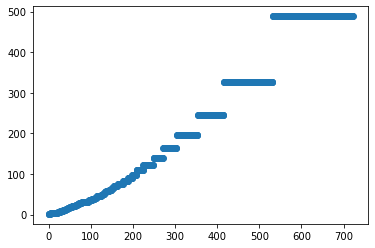

In [24]:
plt.scatter(list(range(num_verbs)),a_docs / cut_one['doc_freq'])

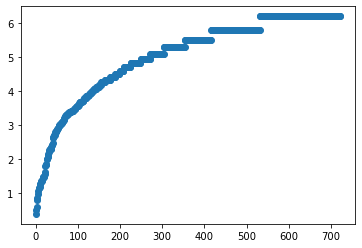

In [25]:
plt.scatter(list(range(num_verbs)),np.log(a_docs / cut_one['doc_freq']))

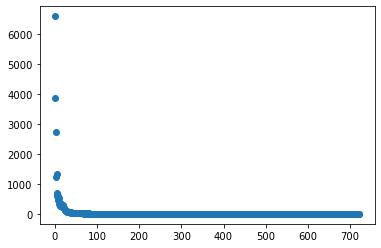

In [26]:
plt.scatter(list(range(num_verbs)),cut_one['tfidf'])

In [27]:
idfs = a_docs / cut_one['doc_freq']

idfs = idfs.to_numpy()



In [28]:
idfs

array([  1.46038864,   1.61487603,   1.80258303,   2.20045045,
         2.29882353,   2.64769648,   2.89910979,   3.12140575,
         3.1516129 ,   3.22442244,   3.53985507,   3.55272727,
         3.77220077,   3.81640625,   3.87698413,   3.93951613,
         4.17521368,   4.30396476,   4.34222222,   4.36160714,
         4.46118721,   4.67464115,   4.95939086,   6.0308642 ,
         6.14465409,   6.42763158,   7.29104478,   7.40151515,
         7.87903226,   8.07438017,   8.42241379,   9.0462963 ,
         9.67326733,   9.86868687,   9.86868687,   9.96938776,
         9.96938776,  10.50537634,  11.22988506,  11.22988506,
        11.63095238,  13.56944444,  14.15942029,  14.58208955,
        14.8030303 ,  15.03076923,  16.01639344,  16.28333333,
        16.55932203,  16.84482759,  17.44642857,  17.76363636,
        18.43396226,  18.43396226,  19.54      ,  19.54      ,
        19.93877551,  19.93877551,  20.35416667,  20.78723404,
        21.23913043,  21.23913043,  21.71111111,  21.71

In [29]:
idfs = np.sort(idfs)
dif_idfs = idfs[1:] - idfs[:-1]

In [30]:
left = idfs[1:]
right = idfs[:-1]

dif_idfs = left - right

In [31]:
dif_idfs.shape

(722,)

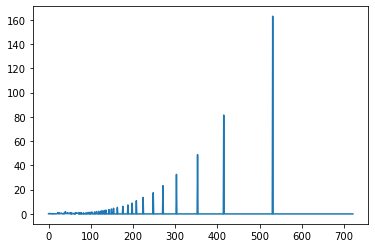

In [32]:
plt.plot(list(range(num_verbs-1)),dif_idfs)

In [33]:
jump_vals = dif_idfs[dif_idfs>=0.7]
num_jumps = len(jump_vals)


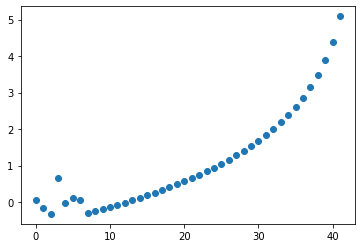

In [34]:
plt.scatter(list(range(num_jumps)),np.log((jump_vals)))

In [35]:
jump_vals

array([  1.07147333,   0.8634132 ,   0.72450871,   1.93849206,
         0.98562421,   1.10603774,   1.05735931,   0.73348348,
         0.77539683,   0.8210084 ,   0.87076649,   0.92518939,
         0.98487903,   1.05053763,   1.12298851,   1.20320197,
         1.29232804,   1.39173789,   1.50307692,   1.62833333,
         1.76992754,   1.93083004,   2.11471861,   2.32619048,
         2.57105263,   2.85672515,   3.19281046,   3.59191176,
         4.07083333,   4.65238095,   5.36813187,   6.26282051,
         7.40151515,   8.88181818,  10.85555556,  13.56944444,
        17.44642857,  23.26190476,  32.56666667,  48.85      ,
        81.41666667, 162.83333333])

In [36]:
np.where(np.abs((dif_idfs - 13.29166667))<0.1)

(array([], dtype=int64),)

In [37]:
# Check cut

idfs[224:]

array([108.55555556, 122.125     , 122.125     , 122.125     ,
       122.125     , 122.125     , 122.125     , 122.125     ,
       122.125     , 122.125     , 122.125     , 122.125     ,
       122.125     , 122.125     , 122.125     , 122.125     ,
       122.125     , 122.125     , 122.125     , 122.125     ,
       122.125     , 122.125     , 122.125     , 122.125     ,
       122.125     , 139.57142857, 139.57142857, 139.57142857,
       139.57142857, 139.57142857, 139.57142857, 139.57142857,
       139.57142857, 139.57142857, 139.57142857, 139.57142857,
       139.57142857, 139.57142857, 139.57142857, 139.57142857,
       139.57142857, 139.57142857, 139.57142857, 139.57142857,
       139.57142857, 139.57142857, 139.57142857, 139.57142857,
       162.83333333, 162.83333333, 162.83333333, 162.83333333,
       162.83333333, 162.83333333, 162.83333333, 162.83333333,
       162.83333333, 162.83333333, 162.83333333, 162.83333333,
       162.83333333, 162.83333333, 162.83333333, 162.83

In [38]:
## want 225

cut_two = cut_one
cut_two = cut_two.iloc[225:]

In [39]:
cut_two

,verb,term_freq,doc_freq,tfidf
225,order,8,8,1.672114
226,launch,8,8,1.672114
227,focus,8,8,1.672114
228,deliver,8,8,1.672114
229,stay,8,8,1.672114
...,...,...,...,...
718,stab,3,2,0.486172
719,panic,2,2,0.324115
720,fake,3,2,0.486172
721,slice,2,2,0.324115


In [40]:
## Too harsh? try again...

#ind_cut = np.where(np.abs((dif_idfs - 2.07142857))<0.1)
ind_cut = np.where(np.abs((dif_idfs - 1.1))<0.01)
ind_cut = int(ind_cut[0])+1
print(ind_cut)

cut_two = cut_one
cut_two = cut_two.iloc[ind_cut:]

54


In [41]:
cut_two

,verb,term_freq,doc_freq,tfidf
54,run,62,50,21.004273
55,walk,60,50,20.326715
56,stop,53,49,17.833210
57,teach,62,49,20.861491
58,felt,62,48,20.717754
...,...,...,...,...
718,stab,3,2,0.486172
719,panic,2,2,0.324115
720,fake,3,2,0.486172
721,slice,2,2,0.324115


### Try with DF?

YESSSS. Much betterz

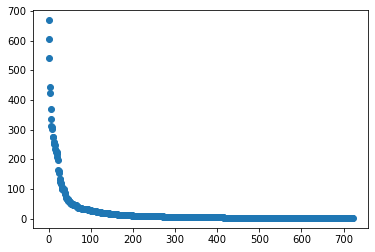

In [42]:
plt.scatter(list(range(num_verbs)),cut_one['doc_freq'])

In [43]:
dfs = cut_one['doc_freq'].to_numpy()

# https://stackoverflow.com/questions/26984414/efficiently-sorting-a-numpy-array-in-descending-order
dfs = np.sort(dfs)[::-1]
dif_dfs = dfs[1:] - dfs[:-1]

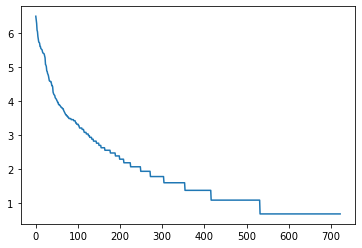

In [44]:
plt.plot(np.log(dfs))

In [45]:
cut_one.iloc[90:100]

,verb,term_freq,doc_freq,tfidf
90,suppose,35,31,10.204628
91,draw,37,31,10.787750
92,discover,39,31,11.370872
93,mention,38,31,11.079311
94,hate,33,30,9.530394
95,drive,33,29,9.437989
96,become,34,29,9.723989
97,let,29,28,8.211578
98,stand,30,28,8.494736
99,figure,30,28,8.494736


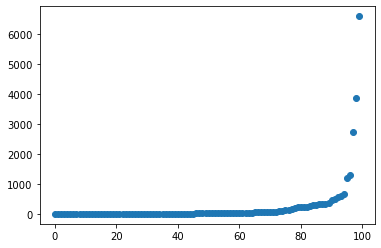

In [46]:
plt.scatter(list(range(100)),np.sort(av["tfidf"].to_numpy()[:100]))

In [47]:
av[av["tfidf"]>500]

,verb,term_freq,doc_freq,tfidf
0,have,2356,669,6580.650244
1,want,1767,605,3853.241578
2,go,1557,542,2738.606163
3,get,936,444,1218.783597
4,do,1070,425,1318.197920
5,like,650,369,682.051834
6,tell,613,337,587.322011
8,say,657,310,582.844107
9,start,594,303,516.490037


In [48]:
common_verbs = av[av["doc_freq"]>150]
list(common_verbs["verb"])

['have',
 'want',
 'go',
 'get',
 'do',
 'like',
 'tell',
 'take',
 'say',
 'start',
 'think',
 'know',
 'try',
 'ask',
 'see',
 'make',
 'use',
 'find',
 'love',
 'put',
 'give',
 'call',
 'show',
 'write',
 'need',
 'saw']

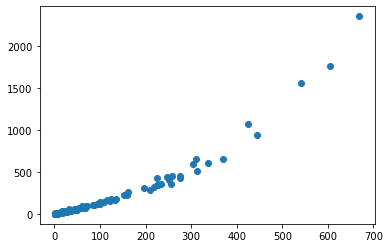

In [49]:
plt.scatter(av["doc_freq"],av["term_freq"])

I think we make the cut words in more than 170 documents. That cuts some verbs, but not a ton. It means that we're throwing out verbs that are used with `he,she,i` in at least 20% of docs. There's also a nice big gap there between 162 (`write`) and 197 (`show`). 

But I can also see a similar argument for above 150 docs. (or at least 15% of the docs). I think we go with this one. 

In [50]:
#197/a_docs

#cut_ind = 23

In [51]:
print(152/a_docs)

cut_ind = 26

0.1555783009211873


In [52]:
cut_two = cut_one
cut_two = cut_two.iloc[cut_ind:]
cut_two

,verb,term_freq,doc_freq,tfidf
26,learn,176,134,89.523530
27,spend,171,132,86.319976
28,meet,174,124,85.147121
29,decide,160,121,77.368958
30,mean,161,116,76.295608
...,...,...,...,...
718,stab,3,2,0.486172
719,panic,2,2,0.324115
720,fake,3,2,0.486172
721,slice,2,2,0.324115


### Cut the two M and F corpora down

This has to happen in two steps. 

1. We need to remove any verbs that are in the M or F corpora that are not in `cut_two`
2. Then remove any verbs that are not in both the M and F corpora after step 1

In [73]:
two_verbs = list(set(cut_two["verb"]))

print(two_verbs)


['earn', 'title', 'ride', 'hurt', 'produce', 'dump', 'determine', 'arrest', 'pan', 'urge', 'decide', 'learn', 'mean', 'seek', 'drill', 'match', 'bend', 'hunch', 'swim', 'cross', 'hand', 'pull', 'cofounded', 'color', 'bury', 'confront', 'rebuild', 'complete', 'launch', 'throw', 'pump', 'live', 'line', 'whisper', 'lay', 'witness', 'check', 'spin', 'supply', 'choose', 'reduce', 'deceive', 'enter', 'draw', 'sit', 'scan', 'nail', 'train', 'panic', 'free', 'protect', 'adapt', 'shut', 'portray', 'fetch', 'return', 'tend', 'resent', 'sign', 'attend', 'devise', 'catalog', 'land', 'agree', 'affect', 'hasten', 'gather', 'encounter', 'slam', 'follow', 'engage', 'lean', 'include', 'provide', 'bruise', 'demonstrate', 'charge', 'serve', 'appreciate', 'juxtapose', 'stay', 'commission', 'sew', 'text', 'enjoy', 'lock', 'imagine', 'congratulate', 'belong', 'discuss', 'consider', 'conduct', 'trust', 'risk', 'swallow', 'hear', 'prepare', 'understand', 'track', 'surprise', 'hug', 'ruin', 'teach', 'bang', 'b

In [74]:
m_pp_v_df

,subject,verb,doc_freq,term_freq,term_rfreq,tfidf,speaker_gender
0,i,have,432,1310,0.016263,2690.317896,man
1,i,want,430,1207,0.014984,2455.389603,man
2,i,go,376,1062,0.013184,1697.115268,man
3,i,get,291,589,0.007312,667.774996,man
4,i,do,274,645,0.008007,684.547118,man
...,...,...,...,...,...,...,...
1713,he,hook,1,1,0.000012,0.152547,man
1714,i,glance,1,1,0.000012,0.152547,man
1715,i,glimpse,1,1,0.000012,0.152547,man
1716,i,glue,1,1,0.000012,0.152547,man


In [81]:
m_two = m_pp_v_df[m_pp_v_df["verb"].isin(two_verbs)]
m2verbs = list(set(m_two["verb"]))

m_two.shape

(1164, 7)

In [82]:
w_two = w_pp_v_df[w_pp_v_df["verb"].isin(two_verbs)]
w2verbs = list(set(w_two["verb"]))

w_two.shape

(801, 7)

In [83]:
m_cut3 = m_two[m_two["verb"].isin(w2verbs)]
m3verbs = list(set(m_cut3["verb"]))

m_cut3.shape

(887, 7)

In [84]:
w_cut3 = w_two[w_two["verb"].isin(m2verbs)]
w3verbs = list(set(w_cut3["verb"]))

w_cut3.shape

(764, 7)

In [67]:
m_cut3

,subject,verb,doc_freq,term_freq,term_rfreq,tfidf,speaker_gender
27,i,learn,84,110,0.001366,51.775912,man
28,i,mean,82,110,0.001366,51.195231,man
30,i,spend,81,105,0.001304,48.590691,man
31,i,meet,77,104,0.001291,47.025810,man
32,i,decide,75,104,0.001291,46.472787,man
...,...,...,...,...,...,...,...
1685,he,improvise,1,2,0.000025,0.305094,man
1687,he,impersonate,1,1,0.000012,0.152547,man
1700,he,hug,1,1,0.000012,0.152547,man
1701,he,hop,1,1,0.000012,0.152547,man


In [68]:
w_cut3

,subject,verb,doc_freq,term_freq,term_rfreq,tfidf,speaker_gender
23,i,spend,41,49,0.001841,26.867538,woman
25,i,meet,39,58,0.002180,30.953596,woman
28,i,learn,38,48,0.001804,25.266508,woman
29,i,remember,37,49,0.001841,25.435831,woman
31,i,decide,34,39,0.001466,19.393590,woman
...,...,...,...,...,...,...,...
1050,he,accompany,1,1,0.000038,0.180592,woman
1051,i,issue,1,1,0.000038,0.180592,woman
1053,i,judge,1,1,0.000038,0.180592,woman
1054,i,kick,1,1,0.000038,0.180592,woman


In [69]:
df_cut = pd.concat([m_cut3, w_cut3])
df_cut=df_cut.reindex(columns=['speaker_gender', 'subject', 'verb', 'term_freq', 'doc_freq', 'tfidf'])

df_cut

,speaker_gender,subject,verb,term_freq,doc_freq,tfidf
27,man,i,learn,110,84,51.775912
28,man,i,mean,110,82,51.195231
30,man,i,spend,105,81,48.590691
31,man,i,meet,104,77,47.025810
32,man,i,decide,104,75,46.472787
...,...,...,...,...,...,...
1050,woman,he,accompany,1,1,0.180592
1051,woman,i,issue,1,1,0.180592
1053,woman,i,judge,1,1,0.180592
1054,woman,i,kick,1,1,0.180592


In [296]:
df_cut.to_csv("../output/tfidf_by_speaker_trimmed.csv")

### Check verbs match

In [85]:
len(set(w3verbs))

487

In [86]:
len(set(m3verbs))

487

In [89]:
# Verbs in male speaker list not in female speaker list
male_not_female = set(m2verbs).difference(m3verbs)

m_one_side = m_two[m_two["verb"].isin(list(male_not_female))]

In [92]:
male_not_female

{'abandon',
 'accumulate',
 'affect',
 'agree',
 'alter',
 'analyze',
 'announce',
 'appeal',
 'arrange',
 'assault',
 'attack',
 'award',
 'back',
 'bang',
 'beg',
 'bite',
 'bless',
 'bore',
 'bother',
 'browse',
 'bruise',
 'campaign',
 'cast',
 'catalog',
 'cease',
 'charge',
 'cherish',
 'chew',
 'circle',
 'claim',
 'click',
 'co',
 'cofounded',
 'complain',
 'conceive',
 'congratulate',
 'construct',
 'consume',
 'contemplate',
 'cool',
 'criticize',
 'cruise',
 'dance',
 'debate',
 'defend',
 'delight',
 'demonstrate',
 'destroy',
 'din',
 'dip',
 'disable',
 'disappear',
 'distract',
 'dive',
 'donate',
 'dress',
 'drill',
 'drown',
 'edit',
 'educate',
 'eliminate',
 'endorse',
 'expand',
 'explode',
 'extend',
 'extract',
 'fetch',
 'fire',
 'fold',
 'forgive',
 'form',
 'free',
 'generate',
 'grasp',
 'head',
 'heat',
 'hesitate',
 'highlight',
 'hire',
 'honor',
 'hook',
 'hurt',
 'illustrate',
 'impose',
 'incorporate',
 'inflate',
 'instruct',
 'involve',
 'juxtapose',
 

In [90]:
m_one_side

,subject,verb,doc_freq,term_freq,term_rfreq,tfidf,speaker_gender
201,i,hire,9,15,0.000186,3.441841,man
233,i,test,7,7,0.000087,1.518620,man
238,i,organize,7,7,0.000087,1.518620,man
301,i,forgive,5,6,0.000074,1.213121,man
311,i,involve,5,5,0.000062,1.010934,man
...,...,...,...,...,...,...,...
1649,he,incorporate,1,1,0.000012,0.152547,man
1673,he,free,1,1,0.000012,0.152547,man
1694,he,hurt,1,1,0.000012,0.152547,man
1706,i,free,1,2,0.000025,0.305094,man


In [93]:
# Verbs in female speaker list not in male speaker list
female_not_male = set(w2verbs).difference(w3verbs)

w_one_side = w_two[w_two["verb"].isin(list(female_not_male))]

In [94]:
female_not_male

{'adapt',
 'approve',
 'contribute',
 'depict',
 'deserve',
 'direct',
 'endure',
 'fall',
 'feed',
 'handle',
 'haunt',
 'justify',
 'mess',
 'obsess',
 'pack',
 'possess',
 'promote',
 'question',
 'refer',
 'restrict',
 'stun',
 'swallow',
 'tease',
 'tie'}

In [95]:
w_one_side

,subject,verb,doc_freq,term_freq,term_rfreq,tfidf,speaker_gender
220,i,question,4,4,0.000150,0.963614,woman
258,i,pack,3,3,0.000113,0.675870,woman
280,i,handle,3,3,0.000113,0.675870,woman
299,i,adapt,3,3,0.000113,0.675870,woman
312,she,endure,2,2,0.000075,0.412866,woman
326,i,swallow,2,2,0.000075,0.412866,woman
332,i,approve,2,2,0.000075,0.412866,woman
357,i,justify,2,2,0.000075,0.412866,woman
381,i,obsess,2,2,0.000075,0.412866,woman
386,i,haunt,2,2,0.000075,0.412866,woman


# =-=-=-=-=-=-=-= OLD =-=-=-=-=-=-=-=

## Grab just the I's


For each talk, we are just going to extract the `I` subjects using a version of the code from the `03-Gender-SV-TFIDF-OLD` notebook

In [ ]:
# Create a list of the pronouns we want to see
pronouns = ["i"]

# Function to retrive the count the number of times subjects
# I is paired with verbs
def i_svPairs(df, talkIDs):
    # Create an empty data frame
    df_out = pd.DataFrame({'subject' : [], 'verb' : [], 'v_freq' : [], 'v_rfreq' : [], 'TalkID' : []})
    
    # Isolate the SVOs in each talk
    for t in talkIDs:
        temp = df[df["TalkID"] == t]
        temp_i = temp[temp["subject"] == "i"].value_counts(
            subset=['subject', 'verb']).reset_index()
        
        # Re-label the new column from "0" to something human-readable
        temp_i.rename(columns={0:'v_freq'}, inplace=True)

        # Add a column with relative frequency
        temp_i['v_rfreq'] = temp_i['v_freq'] / temp.shape[0]
        
        # Add the talkID back in 
        temp_i["TalkID"] = t
        
        # Concatenate with previous dataframe
        df_out = pd.concat([df_out, temp_i])
    
    # Clean up the output dataframe 
    df_out = df_out.reset_index()
    df_out = df_out.drop(columns = "index")
    
    df_out.v_freq = df_out.v_freq.astype(int)
    df_out.TalkID = df_out.TalkID.astype(int)
    
    return df_out

In [ ]:
test = i_svPairs(svos_mbt,m_talkIDs)

In [ ]:
test